Examples of how to use the BCES fitting code
===================

BCES python module [available on Github](https://github.com/rsnemmen/BCES).

Tested with Python 2x and 3x.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd '/Users/nemmen/Dropbox/codes/python/bces'

/Users/nemmen/Dropbox/codes/python/bces


In [3]:
import bces.bces
import seaborn

# Example 1

Data with errors in $x$ and $y$, no correlation between uncertainties

Reads data (real data taken from this [paper](http://science.sciencemag.org/content/338/6113/1445.full])). The [datafile](https://github.com/rsnemmen/BCES/blob/master/data.npz) is available in the github repository

In [4]:
data=load('data.npz')
xdata=data['x']
ydata=data['y']
errx=data['errx']
erry=data['erry']
cov=data['cov']

Fitting, results such that $y = Ax + B$. *covab* is the resulting covariance matrix which can be used to draw confidence regions.

You need to select the desired BCES method for plotting by setting the variable $i$ below. The methods available are:

| $i$  | Method  |  Description |
|---|---| --- |
| 0  | $y|x$  | Assumes $x$ as the independent variable |
| 1  |  $x|y$ | Assumes $y$ as the independent variable |
| 2  | bissector  | Line that bisects the $y|x$ and $x|y$. *Do not use this method*, cf. [Hogg, D. et al. 2010, arXiv:1008.4686](http://labs.adsabs.harvard.edu/adsabs/abs/2010arXiv1008.4686H/). |
| 3  | orthogonal  | Orthogonal least squares: line that minimizes orthogonal distances. Should be used when it is not clear which variable should be treated as the independent one |

Please read the [original BCES paper](http://labs.adsabs.harvard.edu/adsabs/abs/1996ApJ...470..706A/) to understand what these different lines mean.

In [5]:
# Selects the desired BCES method for plotting
i=0 

# number of bootstrapping trials
nboot=10000

In [6]:
%%time
# Performs the BCES fit using many cores in parallel
a,b,erra,errb,covab=bces.bces.bcesp(xdata,errx,ydata,erry,cov,nboot)

BCES, 10000 trials... 
4.965041 s
CPU times: user 26 ms, sys: 34.8 ms, total: 60.7 ms
Wall time: 4.97 s


Plot

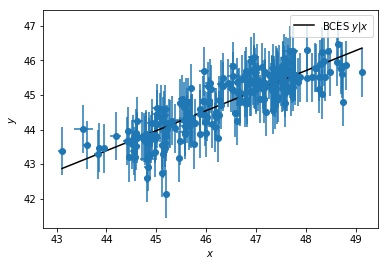

In [7]:
errorbar(xdata,ydata,xerr=errx,yerr=erry,fmt='o')
x=numpy.linspace(xdata.min(),xdata.max())
plot(x,a[i]*x+b[i],'-k',label="BCES $y|x$")
legend(loc='best')
xlabel('$x$')
ylabel('$y$')

## Plot with fit confidence band

Suppose you want to include in the plot a visual estimate of the uncertainty on the fit. This is called the confidence band. The $2\sigma$ confidence interval is 95% sure to contain the best-fit regression line. Note that this is not the same as saying it will contain 95% of the data points. For more information, [check this out](http://graphpad.com/curvefit/linear_regression.htm).

In order to plot the confidence band, you will need to [install the `nmmn` package](https://github.com/rsnemmen/nmmn#installation): 

    pip install nmmn

After installing the package, follow the instructions below to plot the confidence band of your fit.

First we define convenient arrays that encapsulate the fit parameters and their uncertainties—including the covariance.

In [8]:
# array with best-fit parameters
fitm=numpy.array([ a[i],b[i] ])	
# covariance matrix of parameter uncertainties
covm=numpy.array([ (erra[i]**2,covab[i]), (covab[i],errb[i]**2) ])	

# convenient function for a line
def func(x): return x[1]*x[0]+x[2]

Now we estimate the $2\sigma$ confidence band using one of the methods in the `nmmn.stats` module.

In [9]:
import nmmn.stats

# Gets lower and upper bounds on the confidence band 
lcb,ucb,x=nmmn.stats.confbandnl(xdata,ydata,func,fitm,covm,2,0.954,x)

Finally, the plot where the confidence band is displayed in orange. As you can see, it is very narrow.

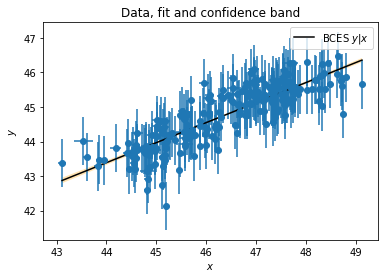

In [10]:
errorbar(xdata,ydata,xerr=errx,yerr=erry,fmt='o')
plot(x,a[i]*x+b[i],'-k',label="BCES $y|x$")
fill_between(x, lcb, ucb, alpha=0.3, facecolor='orange')

legend(loc='best')
xlabel('$x$')
ylabel('$y$')
title("Data, fit and confidence band")

# Example 2

Fake data with random uncertainties in $x$ and $y$. Example prepared by Rogerio Riffel.

Prepares fake data

In [11]:
x=np.arange(1,20)
y=3*x + 4

xer=np.sqrt((x- np.random.normal(x))**2)
yer=np.sqrt((y- np.random.normal(y))**2)

# reescrevendo x e y para serem random
y=numpy.random.normal(y)
x=numpy.random.normal(x)

In [12]:
# simple linear regression
(aa,bb)=numpy.polyfit(x,y,deg=1)
yfit=x*aa+bb

# BCES fit
cov=zeros(len(x))   # no correlation between error measurements
nboot=10000   # number of bootstrapping trials
a,b,aerr,berr,covab=bces.bces.bcesp(x,xer,y,yer,cov,nboot)
ybces=a[3]*x+b[3]  # the integer corresponds to the desired BCES method for plotting (3-ort, 0-y|x, 1-x|y, *don't use bissector*)

BCES, 10000 trials... 
4.780946 s


Plot

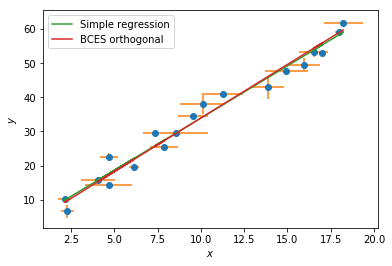

In [13]:
plot(x,y,'o')
errorbar(x,y,xer,yer,ls='None')
plot(x,yfit,label='Simple regression')
plot(x,ybces,label='BCES orthogonal')
legend(loc='best')
xlabel('$x$')
ylabel('$y$')

## Confidence band

Again, make sure you install the [`nmmn`](https://github.com/rsnemmen/nmmn#installation) package before proceeding.

In [14]:
# array with best-fit parameters
fitm=numpy.array([ a[i],b[i] ])	
# covariance matrix of parameter uncertainties
covm=numpy.array([ (aerr[i]**2,covab[i]), (covab[i],berr[i]**2) ])	

Now we estimate the $2\sigma$ confidence band using one of the methods in the `nmmn.stats` module.

In [15]:
# Gets lower and upper bounds on the confidence band 
lcb,ucb,xcb=nmmn.stats.confbandnl(x,y,func,fitm,covm,2,0.954,x)

Finally, the plot where the confidence band is displayed in orange. As you can see, it is very narrow.

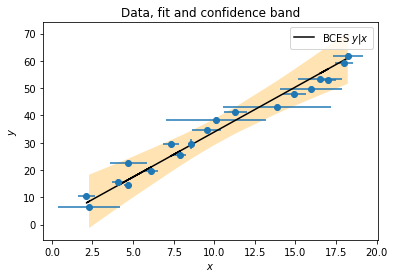

In [16]:
errorbar(x,y,xerr=xer,yerr=yer,fmt='o')
plot(xcb,a[i]*xcb+b[i],'-k',label="BCES $y|x$")
fill_between(xcb, lcb, ucb, alpha=0.3, facecolor='orange')

legend(loc='best')
xlabel('$x$')
ylabel('$y$')
title("Data, fit and confidence band")

# TODO

* [x] ~~include example showing use of confidence contours in fit ("bowtie" plot)~~